# Pulsebuilding Tutorial Flatbean Version
Yapublib! Short intro on how to used this new Broadbean version to simply create pulses.
One could say that going from the previous version to this version empowers the user in a similar way as going from the old dataset to the new data set, in the sense that for these _hard sweeps_ ordinary python syntax can be used very easily (adaptive sweeps are of course not possible).

## System Setup
To setup the system we use the `StationConfigurator` to generate an instance of the AWG5014. However all should be compatible with other AWGs. 

In the next cell we define the instrument instance and create a virtual instrument so that this notebook can also be used without an AWG at hand. Furthermore we define a function to send and plot the forged sequence.

**you need to have the test_requirements.txt installed**

In [1]:
real_instrument_present = False

if real_instrument_present:
    from qdev_wrappers.station_configurator import StationConfigurator
    sc = StationConfigurator()
    awg = sc.load_instrument('AWG5014')
else:
    from qcodes.instrument_drivers.tektronix.AWG5014 import Tektronix_AWG5014
    from qcodes import Instrument
    from contextlib import suppress
    import qcodes.instrument.sims as sims
    visalib = sims.__file__.replace('__init__.py', 'Tektronix_AWG5014C.yaml@sim')
    with suppress(KeyError):
        awg_sim = Instrument.find_instrument('awg_sim')
        awg_sim.close()
    awg = Tektronix_AWG5014('awg_sim',
                            address='GPIB0::1::65535::INSTR',
                            timeout=1,
                            terminator='\n',
                            visalib=visalib)

C:\Users\a-dovoge\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Connected to: QCoDeS AWG5014C (serial:1000, firmware:0.1) in 0.10s


In [2]:
import numpy as np
from broadbean import Segment, SegmentGroup, Element, Sequence
# atoms here are basic functions that create segments
from broadbean.atoms import sine, ramp, flat, zero, on, off
from broadbean.plotting import plotter

def send_and_plot(forged_sequence, SR):
    if real_instrument_present:
        awg.make_send_and_load_awg_file_from_forged_sequence(forged_sequence)
    plotter(forged_sequence, SR=SR)

## Hello World
Lets upload a simple sine wave.

and the actual creation is (almost) self explanatory:

In [4]:
seg = sine(duration=1e-3, frequency=1e3)
# create an element with a single segment on channel `2`
e = Element({2:seg})
s = Sequence([e])
fs = s.forge(SR=1e6)

`fs` is the _forged sequece_ and can be passed to the qcodes driver.

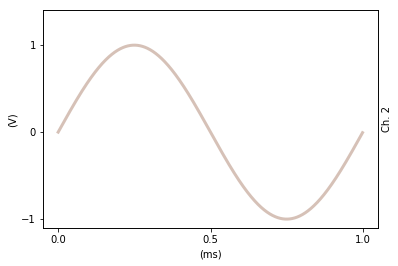

In [5]:
send_and_plot(fs, SR=1e6)

## Segment Groups
If we want to create a segment that is composed by multiple atoms, we need to create a `SegmentGroup`:

In [5]:
# create a square pulse
seg1 = zero(duration=1e-3)
seg2 = flat(duration=1e-3, amplitude=1)
seg3 = zero(duration=1e-3)

pi_pulse = SegmentGroup(seg1, seg2, seg3,
                        duration = 3e-3)
fs = Sequence([Element({1:pi_pulse})]).forge(SR=1e6)

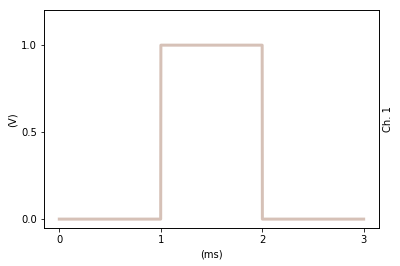

In [6]:
send_and_plot(fs, SR=1e6)

## Symbols
The most significant improvement is that one can define _symbols_. That means we can define a prototype of/recepie for a sequence and parametrize it. A symbol is nothing but a property that has not been given a concrete numeric value but a placeholder for evaluation at forging time. This is simply realized by passing a `str` as the value of a given property
To follow up with the previous example we could specify the amplitude of that pi-pulse:

In [7]:
# create a square pulse
seg1 = zero(duration=1e-3)
seg2 = flat(duration=1e-3, amplitude='pi_amp')
seg3 = zero(duration=1e-3)

pi_pulse = SegmentGroup(seg1, seg2, seg3,
                        duration = 1e3)
s = Sequence([Element({1:pi_pulse})])
# here the sequence s is a recepy for building a pi-pulse for any amplitude
# for getting the actual waveform we need to specify the context and pass it to the forge method
context = {'pi_amp': 0.5}
fs = s.forge(SR=1e6, context=context)

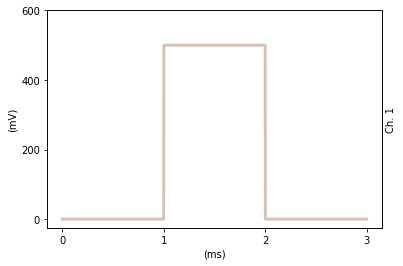

In [8]:
send_and_plot(fs, SR=1e6)

## Transformations
In order to make the feature of symbols really useful we need to take into account dependencies of symbols. So for example if we want to tune the pulse duration and keep the overall duration of the element constant.
For this we can introduce a transformation:

In [9]:
seg1 = zero(duration=1e-1)
seg2 = flat(duration='pulse_duration', amplitude=1)
seg3 = zero(duration='flex_time')

def keep_total_duration_constant(context):
    context['flex_time'] = context['total_duration'] - context['pulse_duration'] - 1e-1
                                 

pi_pulse = SegmentGroup(seg1, seg2, seg3,
                        duration = 'total_duration',
                        transformation=keep_total_duration_constant)
s = Sequence([Element({1:pi_pulse})])
# here the sequence s is a recepy for building a pi-pulse for any amplitude
# for getting the actual waveform we need to specify the context and pass it to the forge method
context = {'pulse_duration': 0.5e-1,
           'total_duration': 3e-1}
fs = s.forge(SR=1e6, context=context)

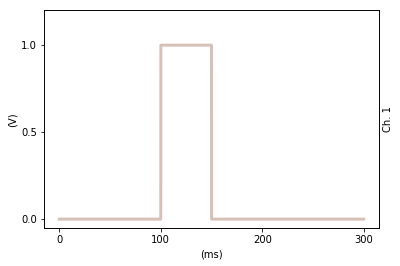

In [10]:
send_and_plot(fs, SR=1e6)

## Making Parametric Sequences
The next logical step is to harness the power of changing symbol values of an element to create a sequence: Here a pulse sequence of centered pulses of increasing length is created.

In [11]:
from broadbean import in_context

seg1 = zero(duration='flex_time')
seg2 = flat(duration='pulse_duration', amplitude=1)
seg3 = zero(duration='flex_time')

# make it centered this time
def keep_total_duration_constant(context):
    context['flex_time'] = 0.5*(context['total_duration'] - context['pulse_duration'])
                                 

pi_pulse = SegmentGroup(seg1, seg2, seg3,
                        duration = 'total_duration',
                        transformation=keep_total_duration_constant)

e = Element({1:pi_pulse})
s = Sequence([in_context(e, pulse_duration=t) for t in np.linspace(0.1e-3,1e-3,5)])

# here the sequence s is a recepy for building a pi-pulse for any amplitude
# for getting the actual waveform we need to specify the context and pass it to the forge method
context = {'total_duration': 3e-3}
fs = s.forge(SR=1e6, context=context)

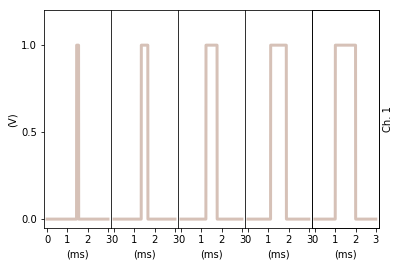

In [12]:
send_and_plot(fs, SR=1e6)

## Adding markers
Markers in this version are treated identical to any other typpe of trace. There are no checks yet if the marker trace is really only 1 or 0.

In [13]:
seg1 = sine(duration='excite_time', phase=np.pi/2, amplitude='amp', frequency=1e3)
# default arguments can be used
seg2 = sine(duration='readout_time', frequency=1e3)

m1 = on(duration='excite_time')
m2 = off(duration='readout_time')

gs = SegmentGroup(seg1, seg2,
                  duration='total_duration')

ms = SegmentGroup(m1, m2,
                  duration='total_duration')

# sequencing information is simply stored as a dict in the elements
e = Element({2:gs,
             '1M1':ms},
            {'nr_rep':2})

s = Sequence([e, e])
times = {'readout_time': 1e-3,
         'excite_time': 2e-3,
        'amp':1}
fs = s.forge(SR=1e6, context=times)

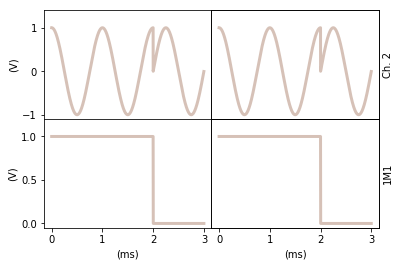

In [14]:
send_and_plot(fs, SR=1e6)

## Routing Signals
The routing module enables to define sequences for abstract channel names and then use a routing dictionary to map those channels to real instrument channels. This seperates the logic of the sequence from the actual wiring. Beyond that one can define sequences that involve multiple instruments.

The following example outputs the marker on a different instrument.

In [15]:
seg1 = sine(duration='excite_time', phase=np.pi/2, amplitude='amp', frequency=1e3)
# default arguments can be used
seg2 = sine(duration='readout_time', frequency=1e3)

m1 = on(duration='excite_time')
m2 = off(duration='readout_time')

gs = SegmentGroup(seg1, seg2,
                  duration='total_duration')

ms = SegmentGroup(m1, m2,
                  duration='total_duration')

e = Element({'MyOutputChannel':gs,
             'MyMarkerChannel':ms},
            {'nr_rep':2})

s = Sequence([e, e])
times = {'readout_time': 1e-3,
         'excite_time': 2e-3,
         'amp': 1}

routing_dict = {'MyOutputChannel': (awg.name, 1),
                'MyMarkerChannel': ('AnotherInstrument', '1M1')}

fs1 = s.forge(SR=1e6,
              context=times,
              routes=routing_dict,
              instrument_name=awg.name)
fs2 = s.forge(SR=1e6,
              context=times,
              routes=routing_dict,
              instrument_name='AnotherInstrument')


# do the same thing for the other instrument
# fs_other = route(fs, routing_dict, ohter_instrument)

IndexError: list index out of range

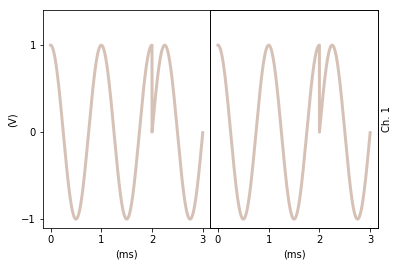

In [16]:
send_and_plot(fs1, SR=1e6)
send_and_plot(fs2, SR=1e6)

## Making Parametric Sequences with transformation on element level
So far we have applied a simple transformation that operates purely on SegmentGroup level. Taking this to the next step includes transformations that act on Element level.

Therefore we consider an example where we add a marker to the flex element with some delay

In [17]:
from broadbean import in_context

seg1 = zero(duration='flex_time')
seg2 = flat(duration='pulse_duration', amplitude=1)
seg3 = zero(duration='flex_time')

pi_pulse = SegmentGroup(seg1, seg2, seg3,
                        duration = 'total_duration')

m1 = off(duration='pre_marker_time')
m2 = on(duration='marker_time')
m3 = off(duration='post_marker_time')

markers = SegmentGroup(m1, m2, m3,
                        duration = 'total_duration')

def mytransformation(context):
    context['flex_time'] = 0.5*(context['total_duration'] - context['pulse_duration'])
    context['pre_marker_time'] = context['flex_time'] + context['marker_delay']
    context['post_marker_time'] = context['total_duration'] - context['marker_time'] - context['pre_marker_time']
                                 

e = Element({1:pi_pulse,
            '1M1':markers},
            transformation=mytransformation)
s = Sequence([in_context(e, pulse_duration=t) for t in np.linspace(0.5e-3,2e-3,5)])

# here the sequence s is a recepy for building a pi-pulse for any amplitude
# for getting the actual waveform we need to specify the context and pass it to the forge method
context = {'total_duration': 3e-3,
          'marker_time': 2e-4,
          'marker_delay':5e-4}
fs = s.forge(SR=1e6, context=context)

It looks like it didn't work correctly but the varying marker delay is an optical illusion

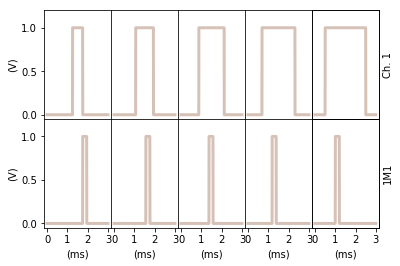

In [18]:
send_and_plot(fs, SR=1e6)

## Serialization
It *should* be possible to serialze the waveforms. This is certainly achievable at the level of the sequence object, when restricting oneself to the used of a defined set of _atoms_. 

It is desirable to have serialization at the highest possible level, i.e. that not the whole forged sequence gets saved but rather the recepie to create it.

One could imagine a simple DSL like yaml that would look like this:

In [19]:
segments:
    seg1:
        type: sine
        duration: excite_time
elements:
    e:
        channels:
            MyOutputChannel: seg1
        sequencing:
            nrep: 3
            
sequence:
    - e
    - e
    

from broadbean.routing import route

seg1 = sine(duration='excite_time', phase=np.pi/2, amplitude='amp', frequency=1e3)
# default arguments can be used
seg2 = sine(duration='readout_time', frequency=1e3)

m1 = on(duration='excite_time')
m2 = off(duration='readout_time')

gs = SegmentGroup(seg1, seg2,
                  duration='total_duration')

ms = SegmentGroup(m1, m2,
                  duration='total_duration')

e = Element({'MyOutputChannel':gs,
             'MyMarkerChannel':ms},
            {'nr_rep':2})

s = Sequence([e, e])
times = {'readout_time': 1e-3,
         'excite_time': 2e-3}

fs = s.forge(SR=1e6, context=times)

routing_dict = {'MyOutputChannel': ('AWG5014', 1),
                'MyMarkerChannel': ('AntoherInstrument', '1M1')}

fs_awg = route(fs, routing_dict, awg)
# do the same thing for the other instrument
# fs_other = route(fs, routing_dict, ohter_instrument)

SyntaxError: invalid syntax (<ipython-input-19-f3192ac4932f>, line 1)

## Forge as meta data only
For the time being the sequences can be stored as meta data. Instead of rendering the segments out in the form of an np.ndarray, the atom name and the arguments are stored.

In [5]:
seg1 = sine(duration='excite_time', phase=np.pi/2, amplitude='amp', frequency=1e3)
seg2 = sine(duration='readout_time', frequency=1e3)
m1 = on(duration='excite_time')
m2 = off(duration='readout_time')
gs = SegmentGroup(seg1, seg2,
                  duration='total_duration')
ms = SegmentGroup(m1, m2,
                  duration='total_duration')
e = Element({2:gs,
             '1M1':ms},
            {'nr_rep':2})

s = Sequence([e, e])
times = {'readout_time': 1e-3,
         'excite_time': 2e-3,
        'amp':1}
fs = s.forge(SR=1e6, context=times, meta_data_only=True)

In [6]:
fs

[{'data': {2: ({'atom': 'sine',
     'args': {'phase': 1.5707963267948966,
      'amplitude': 1,
      'frequency': 1000.0,
      'duration': 0.002}},
    {'atom': 'sine', 'args': {'frequency': 1000.0, 'duration': 0.001}}),
   '1M1': ({'atom': 'on', 'args': {'duration': 0.002}},
    {'atom': 'off', 'args': {'duration': 0.001}})},
  'sequencing': {'nr_rep': 2}},
 {'data': {2: ({'atom': 'sine',
     'args': {'phase': 1.5707963267948966,
      'amplitude': 1,
      'frequency': 1000.0,
      'duration': 0.002}},
    {'atom': 'sine', 'args': {'frequency': 1000.0, 'duration': 0.001}}),
   '1M1': ({'atom': 'on', 'args': {'duration': 0.002}},
    {'atom': 'off', 'args': {'duration': 0.001}})},
  'sequencing': {'nr_rep': 2}}]